In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0a0+d0d6b1f


## Choosing a model

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image preprocessing

In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f1ab0456790>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing

In [5]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Setting up input images and texts

In [6]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "0": "a number with the value zero",
    "1": "a number with the value one",
    "2": "a number with the value two",
    "3": "a number with the value three",
    "4": "a number with the value four",
    "5": "a number with the value five",
    "6": "a number with the value six",
    "7": "a number with the value seven",
    "8": "a number with the value eight",
    "9": "a number with the value nine"
}

In [8]:
from torchvision import transforms

val_set = ColoredMNIST(root='./data',
                       env='val',
                       transform= transforms.Compose([transforms.ToTensor()]))

Colored MNIST dataset already exists


In [9]:
descriptions

{'0': 'a number with the value zero',
 '1': 'a number with the value one',
 '2': 'a number with the value two',
 '3': 'a number with the value three',
 '4': 'a number with the value four',
 '5': 'a number with the value five',
 '6': 'a number with the value six',
 '7': 'a number with the value seven',
 '8': 'a number with the value eight',
 '9': 'a number with the value nine'}

In [10]:
def find_0_to_9_samples(dataset):
    """
    Returns the first 10 indexes with for the numbers 0-9 from a provided dataset
    """
    nroi_idx = [] # indexes of number of interest

    for nroi in range(10):
        for i in range(len(dataset)):
            if (val_set[i][1] == nroi):
                nroi_idx.append(i)
                break

    return nroi_idx

Colored MNIST dataset already exists


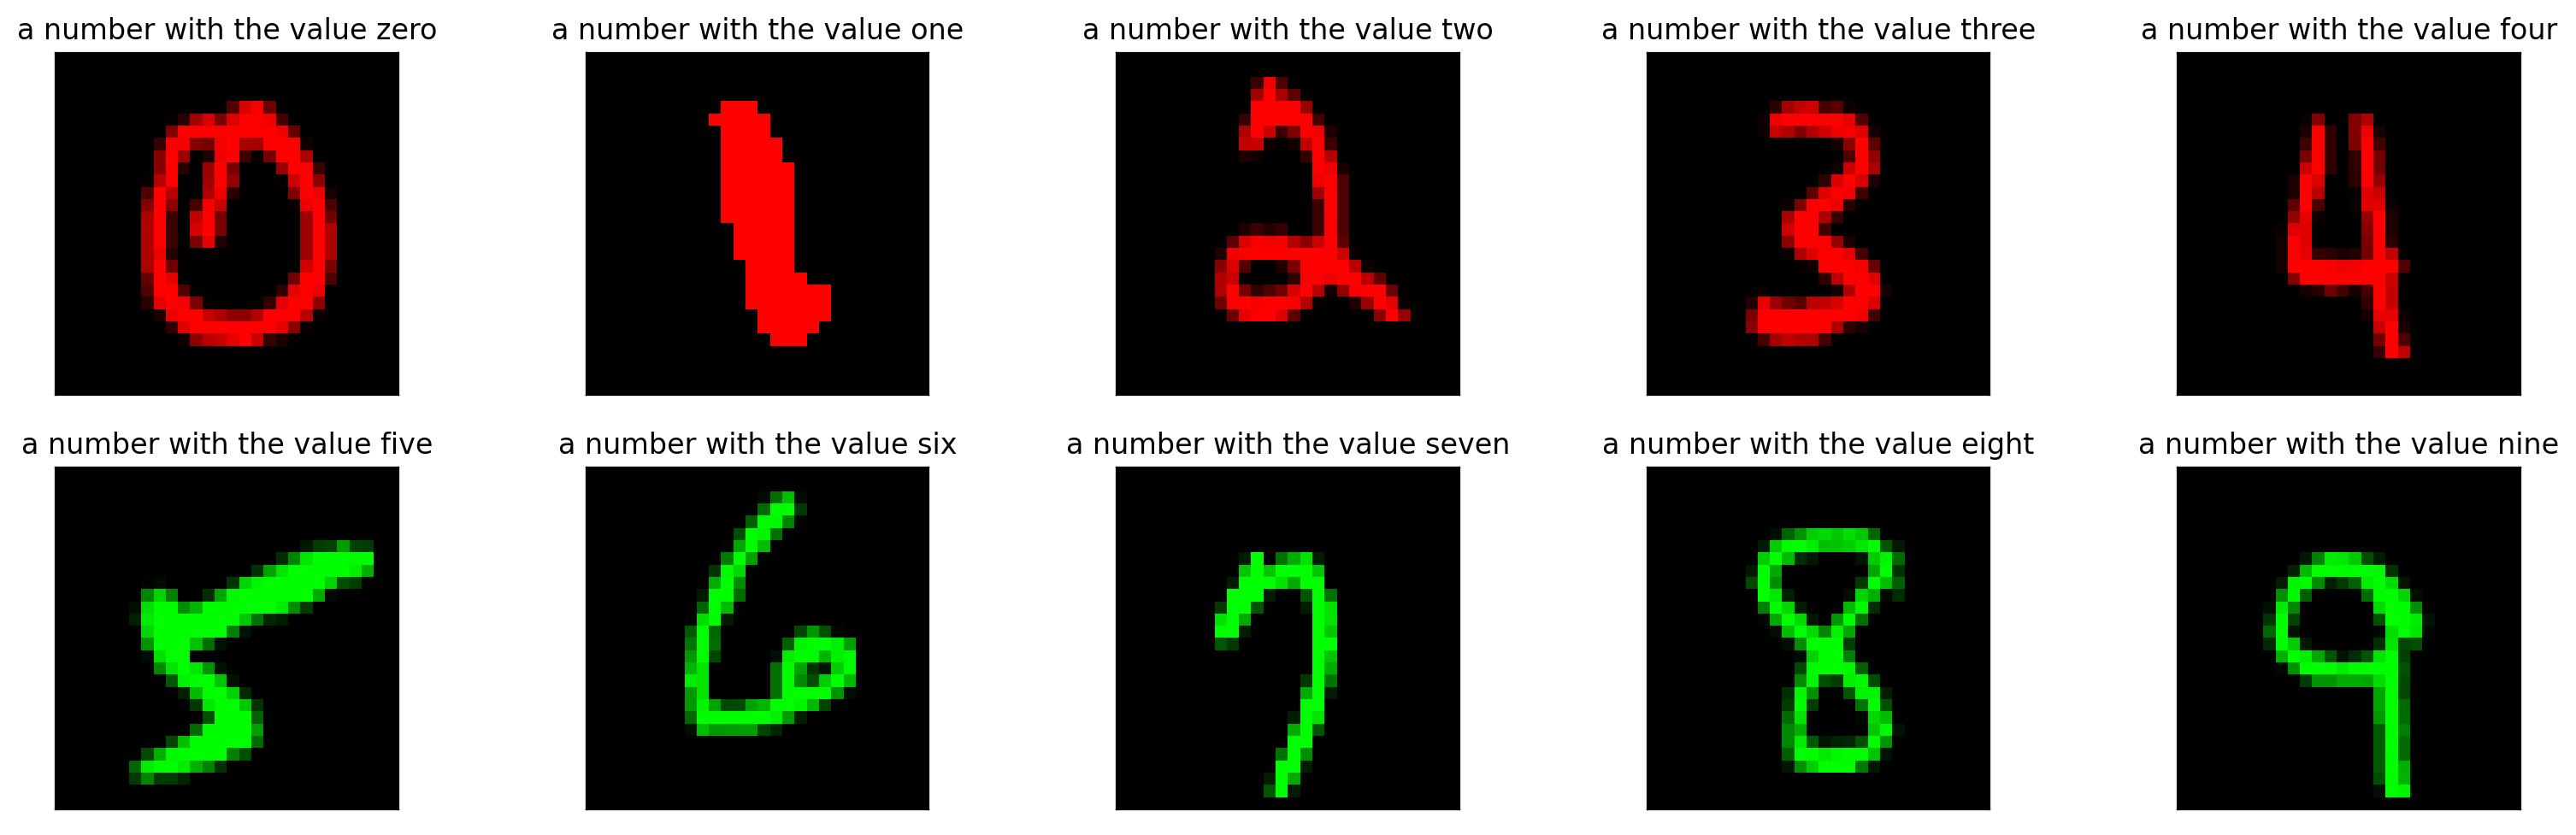

In [11]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

val_set = ColoredMNIST(root='./data',
                       env='val',
                       transform= transforms.Compose([transforms.ToTensor()]))
transform = transforms.ToPILImage()

nroi_idx = find_0_to_9_samples(val_set) # indexes for the numbers of interest (0-9)

for idx in nroi_idx:
    
    image = transform(val_set[idx][0])
    ground_truth_label = val_set[idx][1]
  
    plt.subplot(2, 5, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{descriptions[str(ground_truth_label)]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[str(ground_truth_label)])

plt.tight_layout()

## Building features

In [12]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [13]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

In [14]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

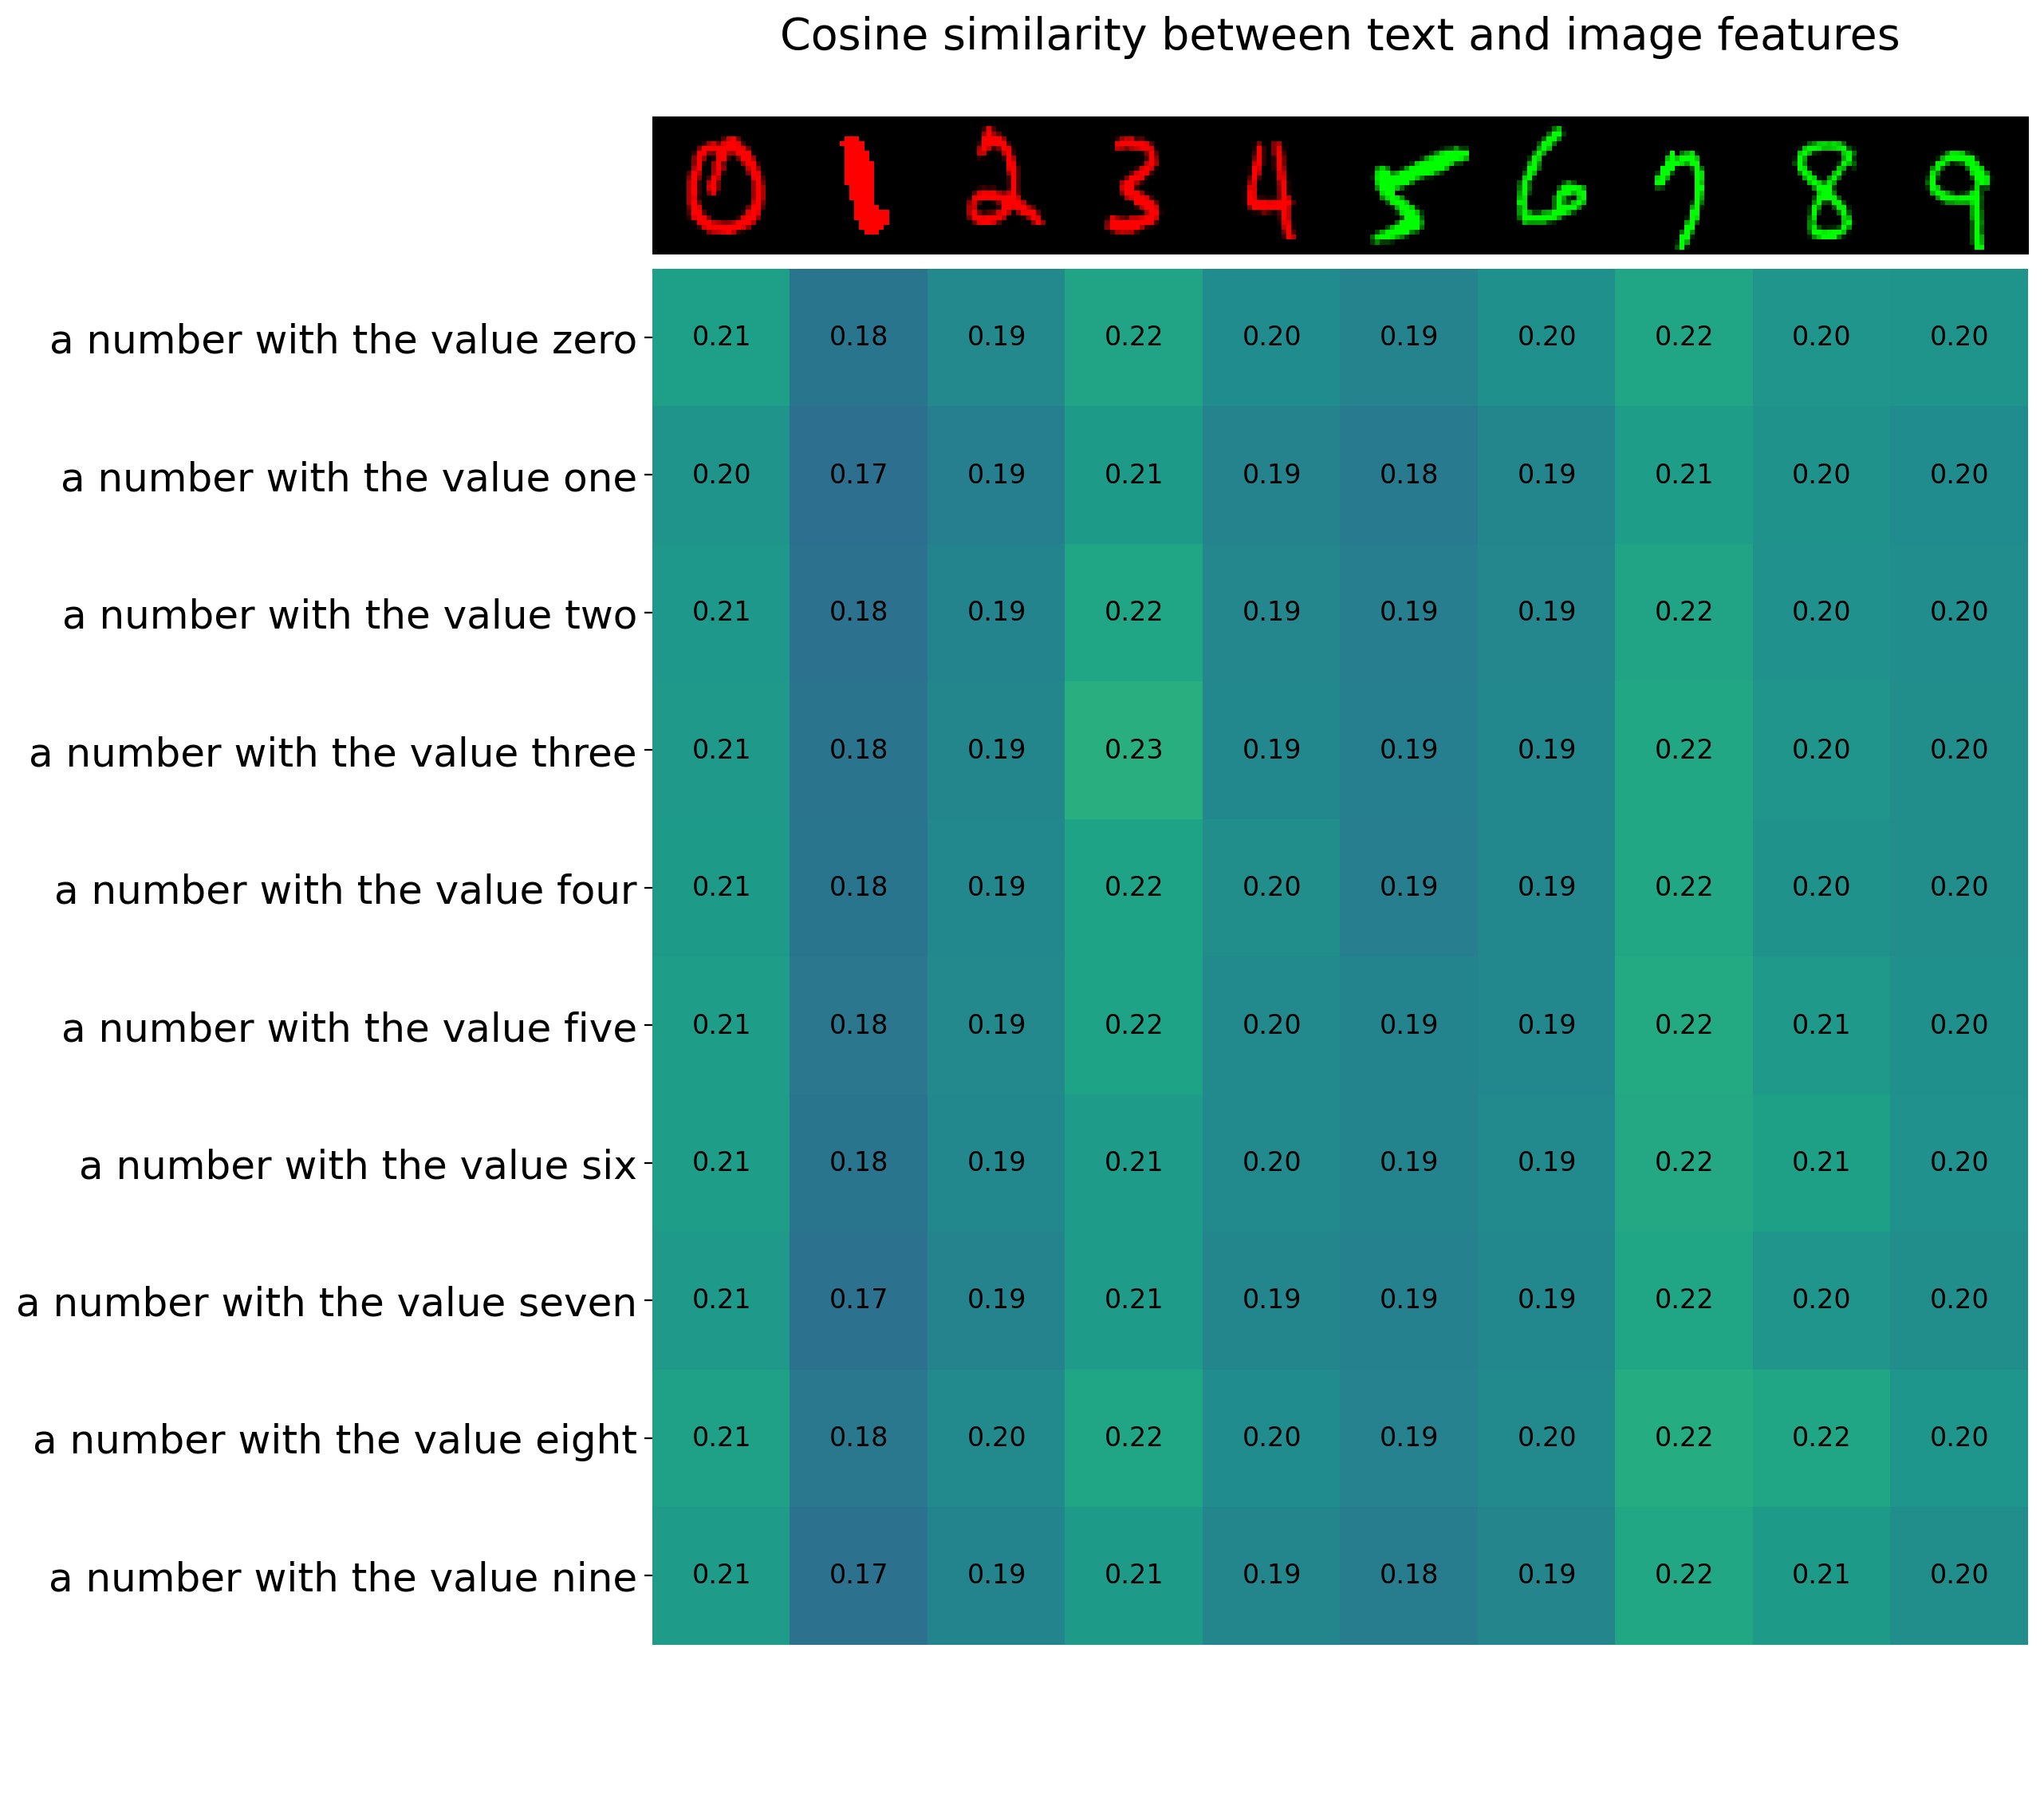

In [15]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

## Zero-Shot Image Classification

In [16]:
number_classes = []
number_classes.append("zero")
number_classes.append("one")
number_classes.append("two")
number_classes.append("three")
number_classes.append("four")
number_classes.append("five")
number_classes.append("six")
number_classes.append("seven")
number_classes.append("eight")
number_classes.append("nine")
text_descriptions = [f"This is a photo of a {label}" for label in number_classes]

text_descriptions

['This is a photo of a zero',
 'This is a photo of a one',
 'This is a photo of a two',
 'This is a photo of a three',
 'This is a photo of a four',
 'This is a photo of a five',
 'This is a photo of a six',
 'This is a photo of a seven',
 'This is a photo of a eight',
 'This is a photo of a nine']

In [17]:
text_descriptions = []
text_descriptions.append('a photo of the number: "0".')
text_descriptions.append('a photo of the number: "1".')
text_descriptions.append('a photo of the number: "2".')
text_descriptions.append('a photo of the number: "3".')
text_descriptions.append('a photo of the number: "4".')
text_descriptions.append('a photo of the number: "5".')
text_descriptions.append('a photo of the number: "6".')
text_descriptions.append('a photo of the number: "7".')
text_descriptions.append('a photo of the number: "8".')
text_descriptions.append('a photo of the number: "9".')
text_descriptions

['a photo of the number: "0".',
 'a photo of the number: "1".',
 'a photo of the number: "2".',
 'a photo of the number: "3".',
 'a photo of the number: "4".',
 'a photo of the number: "5".',
 'a photo of the number: "6".',
 'a photo of the number: "7".',
 'a photo of the number: "8".',
 'a photo of the number: "9".']

In [18]:
text_tokens = clip.tokenize(text_descriptions).cuda()

In [19]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [20]:
text_probs.shape

torch.Size([10, 10])

In [21]:
top_labels

tensor([[0, 9, 8, 1, 3],
        [3, 1, 2, 4, 7],
        [0, 3, 4, 8, 1],
        [3, 2, 8, 1, 4],
        [4, 0, 3, 1, 2],
        [3, 5, 6, 2, 1],
        [3, 4, 2, 1, 0],
        [3, 2, 1, 7, 8],
        [8, 9, 3, 6, 1],
        [0, 8, 3, 1, 2]])

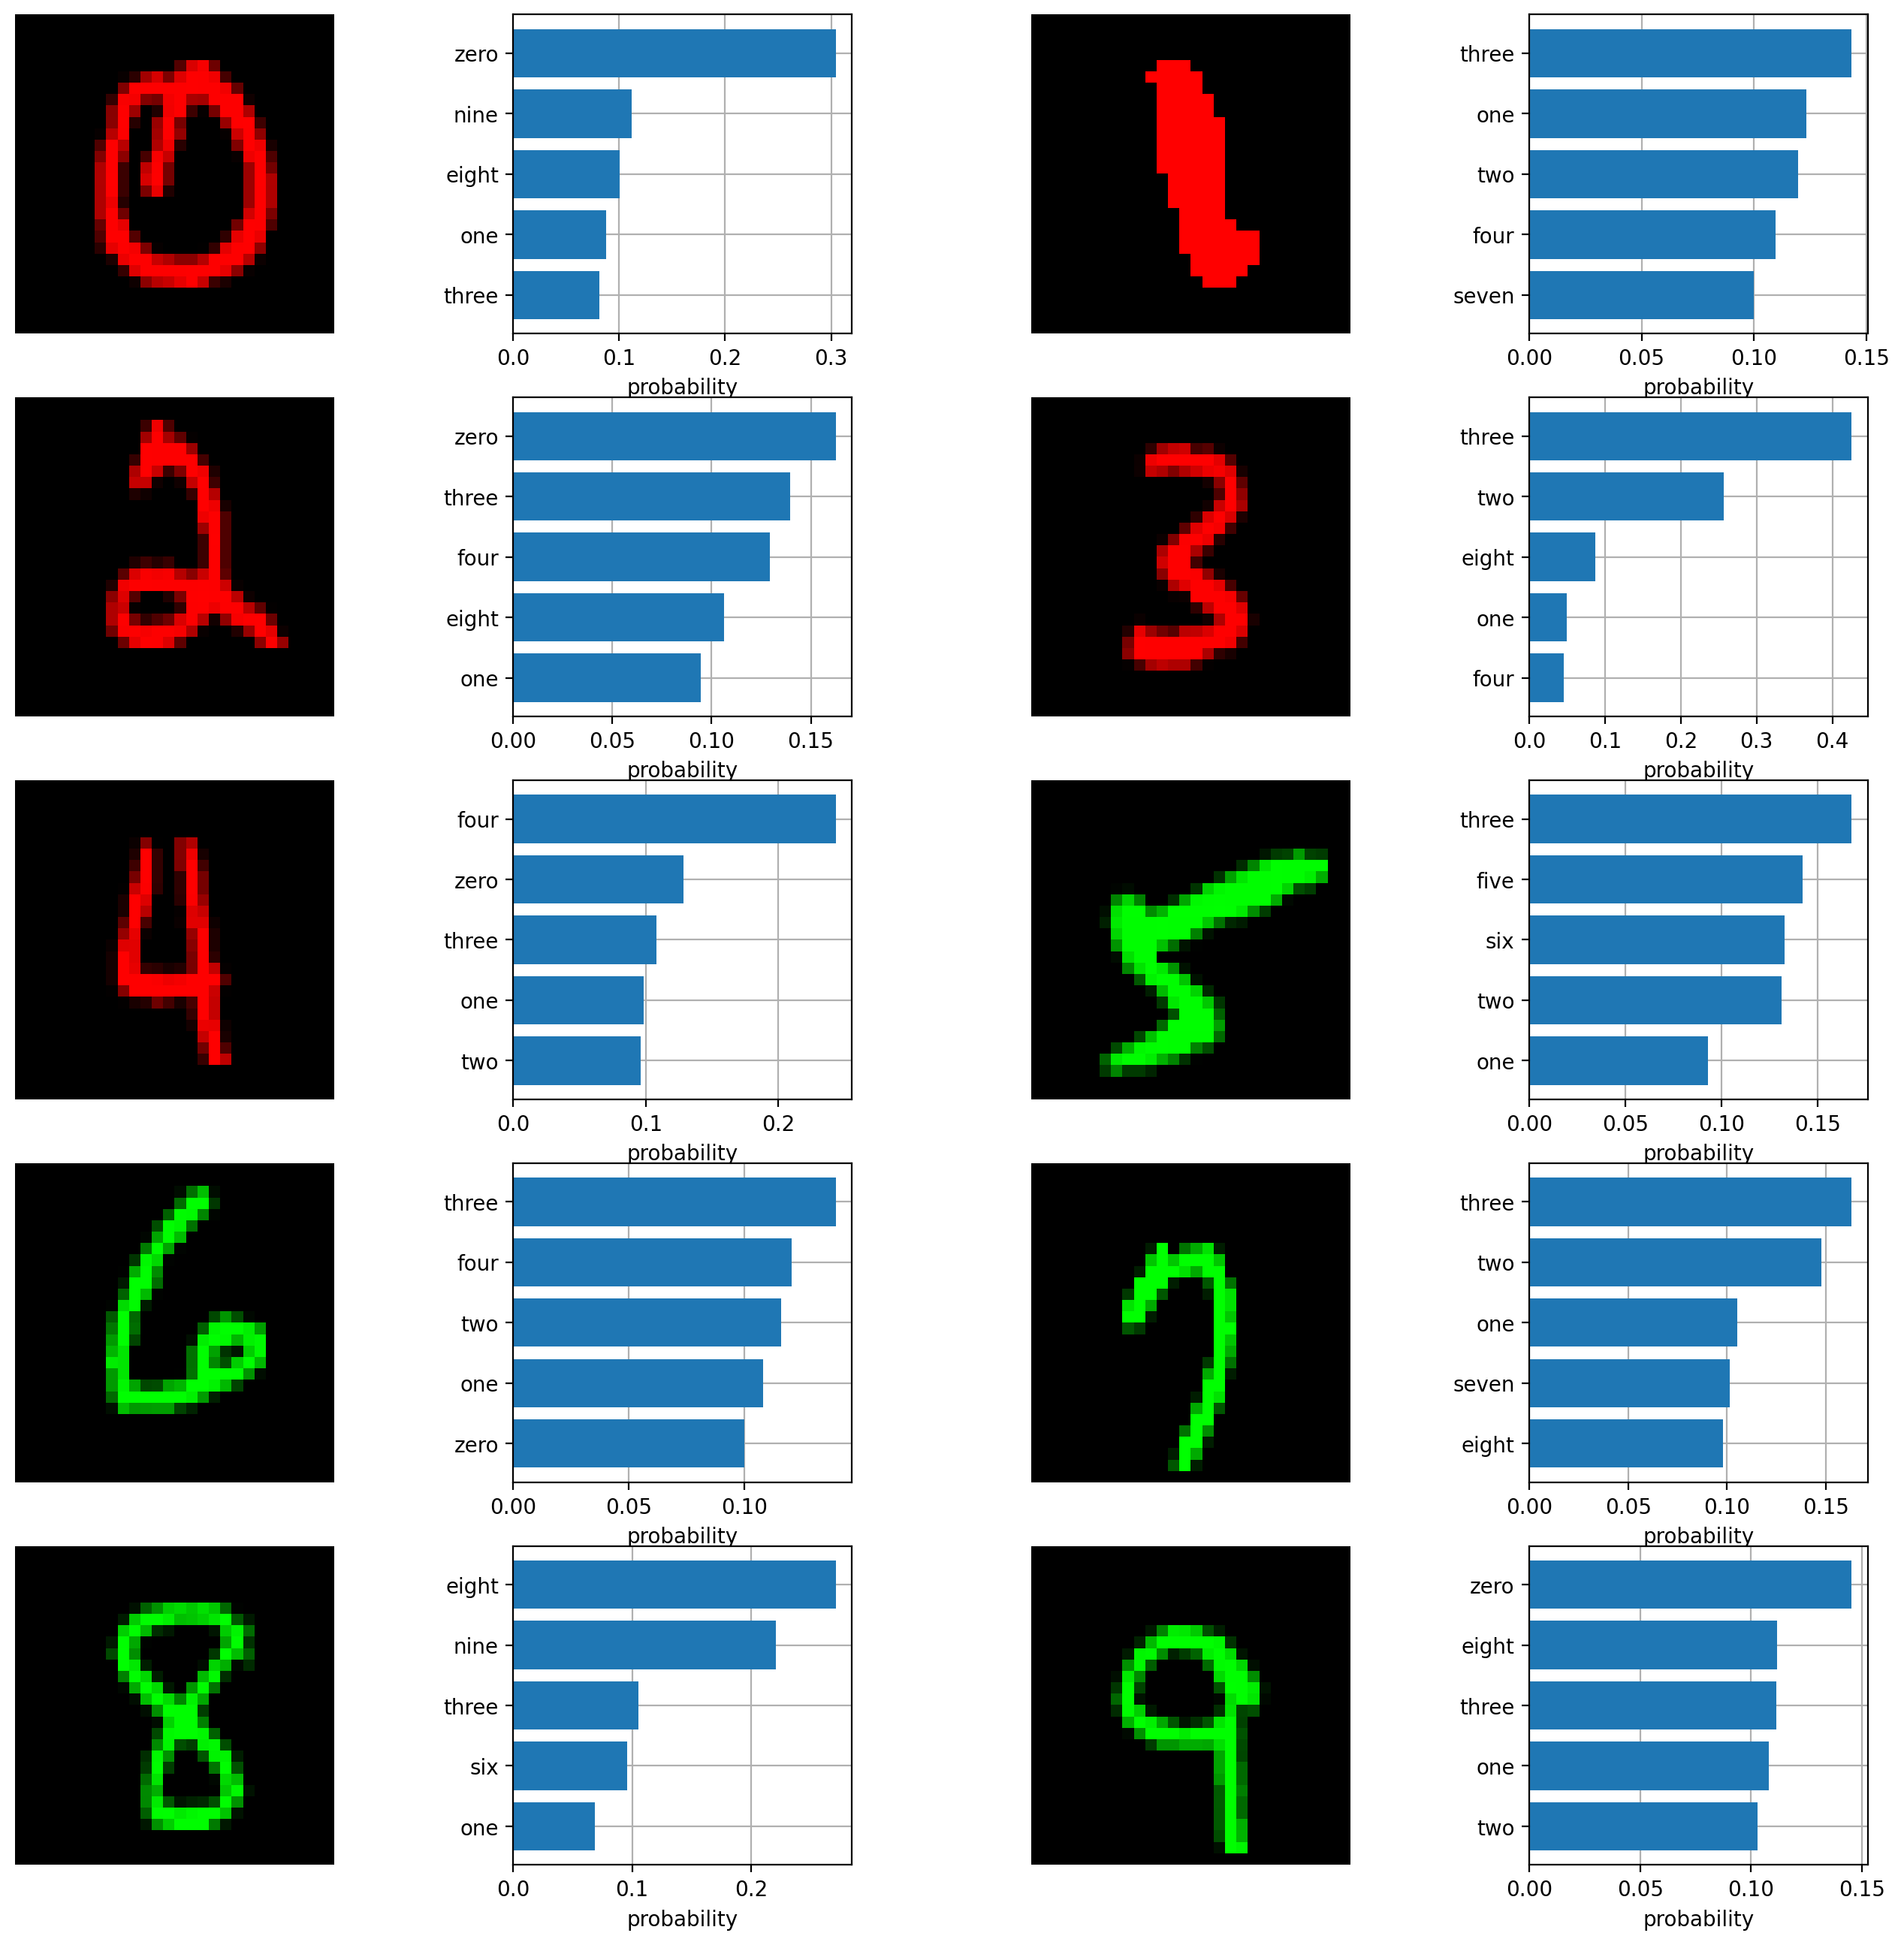

In [22]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [number_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Test performance of the clip model on the colored mnist dataset

In [130]:
from utils.clip_utils import *

# parameters
size_of_batch = 128

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=size_of_batch,
                                           shuffle=True,
                                           num_workers=10)

# len(=nr_of_batches)*batch_size=nr_of_samples
# len(val_loader)-1 full batches with a size of 128 images
# one last batch with the remaining <128 images
#(len(val_loader)-1) * 128 + 16 

asses_clip_performance(model, preprocess, text_descriptions, val_loader, dataset_name="Validation")

ModuleNotFoundError: No module named 'utils.clip_utils'